In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

import numpy.polynomial.polynomial as poly

# random
rng = np.random.default_rng()

from filterbank.components import Filterbank, TransmissionLine, ManifoldFilter, DirectionalFilter, BaseFilter

plt.style.use('~/Repos/louis-style-docs/default.mplstyle')

fig_path = "./figures/"


In [2]:
nF = int(2e4)
f = np.linspace(200e9,480e9,nF)

f0_single = 330e9

f0_min = 210e9
f0_max = 460e9


Z0_res = 86.5
eps_eff_res = 29.9
Qi_res = 1200


Z0_thru = 80.6
eps_eff_thru = 30.9

TL_thru = TransmissionLine(Z0_thru,eps_eff_thru,Qi=9000)

TL_res = TransmissionLine(Z0_res,eps_eff_res,Qi=np.inf)
TL_res_lossy = TransmissionLine(Z0_res,eps_eff_res,Qi=Qi_res)

TransmissionLinesDict = {
    'through' : TL_thru,
    'resonator' : TL_res,
    'MKID' : TL_thru
}

TransmissionLinesLossyDict = {
    'through' : TL_thru,
    'resonator' : TL_res_lossy,
    'MKID' : TL_thru
}



In [3]:
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none'))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch


def plot_centered():
    plot = plt.gcf()
    return plot.add_axes([0.18,0.15,0.64,0.75])

def plotstep_add_S_params(f, Filter: BaseFilter,ax: plt.Axes=None):
    if ax == None:
        ax = plt.gca()

    S_param_list = [
        Filter.S11_absSq,
        Filter.S21_absSq,
        Filter.S31_absSq
    ]

    if Filter.S41_absSq is not None:
        S_param_list.append(Filter.S41_absSq)

    return [line for Sii in S_param_list for line in ax.plot(f/1e9, Sii)]

def plotstep_add_analytical_model(f,ax: plt.Axes=None):
    if ax == None:
        ax = plt.gca()

    S_param_list = [
        S11_func(f),
        S21_func(f),
        S31_func(f),
        S41_func(f),
    ]
    
    return [line for Sii in S_param_list for line in ax.plot(f/1e9, Sii)]

def plotstep_percentage(lines):
    for line in lines:
        line.set_ydata(line.get_ydata()*100)
        line.axes.set_ylim(0,100)

def plotstep_dB(lines):
    for line in lines:
        line.set_ydata(10*np.log10(line.get_ydata()))
        line.axes.set_ylim(-30,0)

def plotstep_add_filterbank(f, FB: Filterbank, ax: plt.Axes=None):
    if ax == None:
        ax = plt.gca()

    S31_all = np.transpose(FB.S31_absSq_list)

    #ax
    cmap = cm.get_cmap('rainbow').copy()
    norm = mpl.colors.Normalize(vmin=0, vmax=FB.n_filters)

    return [line for i,S31_absSq in enumerate(S31_all) for line in ax.plot(f/1e9,S31_absSq,color=cmap(norm(i)))]
    
def make_bins_from_max(x,y,binwidth=0.05):
    max_xy = np.max((np.max(np.abs(x)), np.max(np.abs(y))))
    binlim = (int(max_xy/binwidth) + 1) * binwidth
    return np.arange(-binlim, binlim + binwidth, binwidth)

def format_compact_grid(fig):
    for index,ax in enumerate(fig.axes):
        ss = ax.get_subplotspec()
        ax.sharey(fig.axes[0])
        ax.sharex(fig.axes[0])
        
        ax.tick_params(labelleft=ss.is_first_col())
        ax.tick_params(labelright=ss.is_last_col())
        ax.tick_params(labelbottom=ss.is_last_row())
        ax.tick_params(labeltop=ss.is_first_row())

def violinplot_pretty(ax,data,labels=None):
    vplot = ax.violinplot(data,showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xticks([1,2],labels=labels)
    ax.tick_params(axis="x",which="minor",length=0)

    vplot["cmedians"].set_linewidth(2)
    vplot["cmedians"].set_color("C3")

    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    for violin_patch, color in zip(vplot["bodies"],colors[:len(vplot["bodies"])]):
        violin_patch.set_facecolor(color)
        violin_patch.set_alpha(0.5)

In [4]:
## Directional filter, no variance
FB_directional = Filterbank(
    FilterClass=DirectionalFilter,
    TransmissionLines=TransmissionLinesLossyDict,
    f0_min=f0_min,
    f0_max=f0_max,
    Ql=400,
    oversampling=1.25,
    sigma_f0=0,
    sigma_Qc=0,
    compensate=False
)
FB_directional.S(f)
FB_directional.realized_parameters()


(array([4.59573249e+11, 4.58579246e+11, 4.57654544e+11, 4.56731242e+11,
        4.55820540e+11, 4.54910537e+11, 4.54000535e+11, 4.53091233e+11,
        4.52194530e+11, 4.51284528e+11, 4.50388526e+11, 4.49492524e+11,
        4.48595821e+11, 4.47699819e+11, 4.46804517e+11, 4.45908515e+11,
        4.45025813e+11, 4.44130510e+11, 4.43247808e+11, 4.42365806e+11,
        4.41483804e+11, 4.40601802e+11, 4.39719799e+11, 4.38837797e+11,
        4.37969795e+11, 4.37087793e+11, 4.36219791e+11, 4.35351788e+11,
        4.34483786e+11, 4.33615784e+11, 4.32747782e+11, 4.31879780e+11,
        4.31025078e+11, 4.30157775e+11, 4.29303073e+11, 4.28449071e+11,
        4.27581769e+11, 4.26741067e+11, 4.25887065e+11, 4.25033063e+11,
        4.24179760e+11, 4.23339058e+11, 4.22499056e+11, 4.21645054e+11,
        4.20805052e+11, 4.19965050e+11, 4.19125048e+11, 4.18298346e+11,
        4.17459044e+11, 4.16619042e+11, 4.15793039e+11, 4.14966337e+11,
        4.14140335e+11, 4.13314333e+11, 4.12488331e+11, 4.116623

In [5]:
def n_filters(f0_min,f0_max,R,oversampling=1.0):
    return int(np.floor(1 + np.log10(f0_max / f0_min) / np.log10(1 + 1 / (R * oversampling))))

# standard D2.0 FB 220 GHz to 440 GHz
standard_num_filters = n_filters(220e9,440e9,500)

# new D2.1 FB 205 GHz t0 470 GHz
new_num_filters = n_filters(210e9,460e9,400,1.25)

print(f"standard num. filters 220 GHz to 440 GHz: {standard_num_filters}")
print(f"new num. filters 205 GHz to 470 GHz: {new_num_filters}")
print(f"difference: {new_num_filters-standard_num_filters}")

standard num. filters 220 GHz to 440 GHz: 347
new num. filters 205 GHz to 470 GHz: 393
difference: 46


In [10]:
c = 3e8

n_filt = n_filters(f0_min,f0_max,400,1.25)

f0 = np.zeros(n_filt)
f0[0] = f0_min
for i in np.arange(1,n_filt):
    f0[i] = f0[i-1] + f0[i-1] / (500)
f0 = np.flip(f0)

lambda0 = c / f0 / np.sqrt(eps_eff_thru)

quarter_lambda0 = lambda0/4

l_fb = np.sum(quarter_lambda0)*2

l_at_filter = 0
for filter_i in range(n_filt):

    l_at_filter += quarter_lambda0[filter_i] * 2

    if l_at_filter > l_fb/2:
        split_point = filter_i
        break

print(f"Split filterbank at filter {split_point} (of {n_filt} filters)")
print(f"Total filterbank length estimate: {l_fb*1e3:.3f} mm")

Split filterbank at filter 234 (of 393 filters)
Total filterbank length estimate: 35.020 mm


meta NOT subset; don't know how to subset; dropped


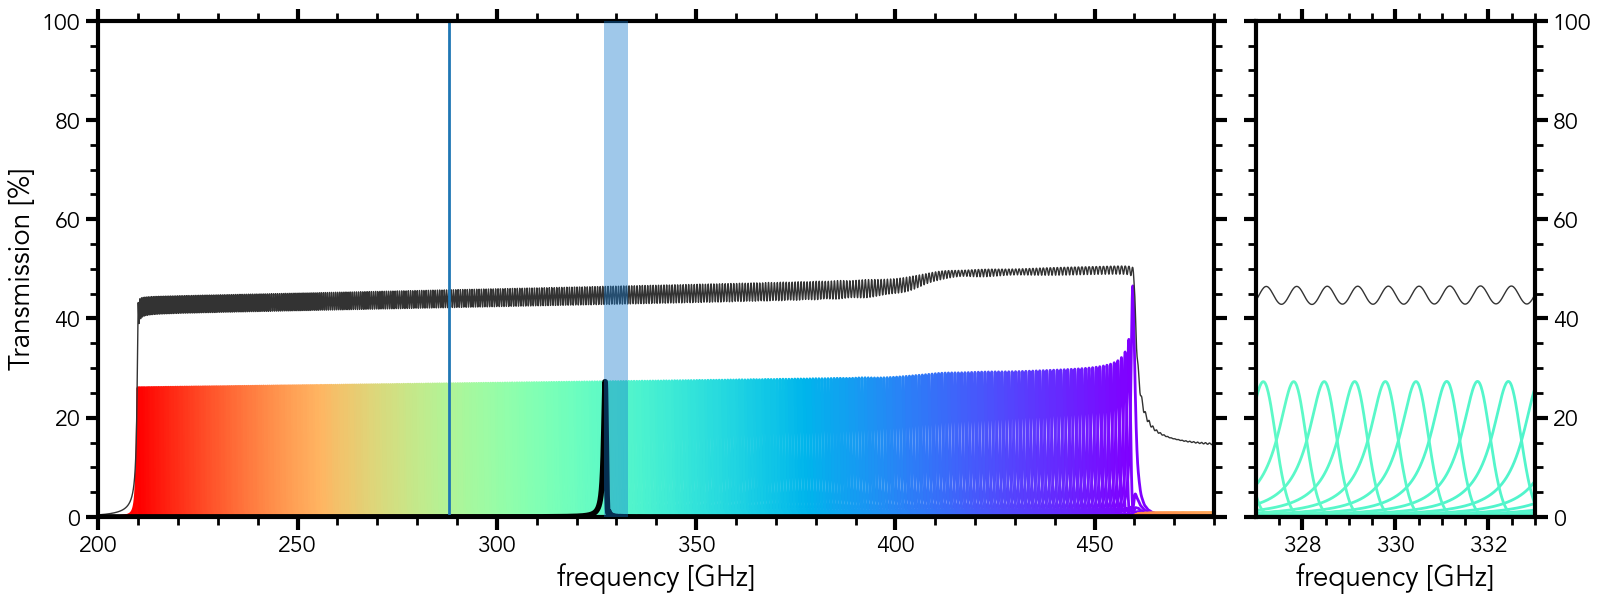

In [11]:
plt.close('all')
plt.rcParams['lines.linewidth'] = 1

gs_kw = dict(top=0.9,hspace=0.1)

fig = plt.figure(figsize=(8,3), layout='constrained')
axs = fig.subplots(1,2,width_ratios=[4,1],sharey='row',gridspec_kw=gs_kw)


##### Filterbank plot, comparison
ax = axs[0]

lines_DF = plotstep_add_filterbank(f,FB_directional,ax)
lines = lines_DF


   

# Sum of filters
sum_filters = np.sum(FB_directional.S31_absSq_list,axis=1)
lines += ax.plot(f/1e9,sum_filters,color="0.2",linestyle="-",linewidth=0.5)


## highlight several individual filters
highlight_index = [170]
lines_highlight = []
for index in highlight_index:
    lines_highlight += ax.plot(f/1e9,FB_directional.S31_absSq_list[:,index],color="0.0",linewidth=2)
lines += lines_highlight

# Make in percentage
plotstep_percentage(lines)


## Highlight zoom section
f_zoom = np.array([327e9,333e9])

left, bottom, width, height = (f_zoom[0]/1e9, 0, (f_zoom[1]-f_zoom[0])/1e9,100)
rect = plt.Rectangle((left, bottom), width, height, facecolor="#17C", alpha=0.4,zorder=1000)

ax.add_patch(rect)
ax.axvline(FB_directional.f0[split_point]/1e9)


ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('Transmission [%]')  # Add a y-label to the axes.
ax.set_xlim(min(f)/1e9,max(f)/1e9)
## ----------------------------------



##### zoom in on section of filterbank
ax_zoom = axs[1]
ax_zoom.tick_params(labelleft=False,labelright=True)

lines_DF = plotstep_add_filterbank(f,FB_directional,ax_zoom)
lines = lines_DF

# highlight a filter in zoom in
lines += ax_zoom.plot(f/1e9,FB_directional.S31_absSq_list[:,390],color="0.0",linewidth=1.5,label="highlighted filter")

# Sum of filters
sum_filters = np.sum(FB_directional.S31_absSq_list,axis=1)
lines += ax_zoom.plot(f/1e9,sum_filters,label=r"$\sum_i{|S_{i1}|^2},\: i \in [3, \dots, N_\mathrm{filt.}+2]$",color="0.2",linestyle="-",linewidth=0.5)

plotstep_percentage(lines)

ax_zoom.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax_zoom.set_xlim(f_zoom[0]/1e9,f_zoom[1]/1e9)
# ax_zoom.set_title("Filter response")  # Add a title to the axes.





n_colors = 60
cmap = cm.get_cmap('rainbow').copy()
rainbow_legend_colors = [cmap(x) for x in np.linspace(1,0,n_colors)]

# ------ get the legend-entries that are already attached to the figure
h, l = ax.get_legend_handles_labels()
h_zoom, l_zoom = ax_zoom.get_legend_handles_labels()

h += h_zoom
l += l_zoom

# ------ append the multicolor legend patches
h.append(MulticolorPatch(rainbow_legend_colors))
l.append(r"$|S_{i1}|^2$")

fig.legend(h, l, loc='upper left', bbox_to_anchor=(0.1, 1.12, 0.8, 0), handler_map={MulticolorPatch: MulticolorPatchHandler()},mode="expand", borderaxespad=0, ncol=3,fontsize='x-small',handlelength=5.0)

# save and plot figure
savestr = fig_path + "filterbank_comparison.pdf"
fig.savefig(fname=savestr,bbox_inches='tight')

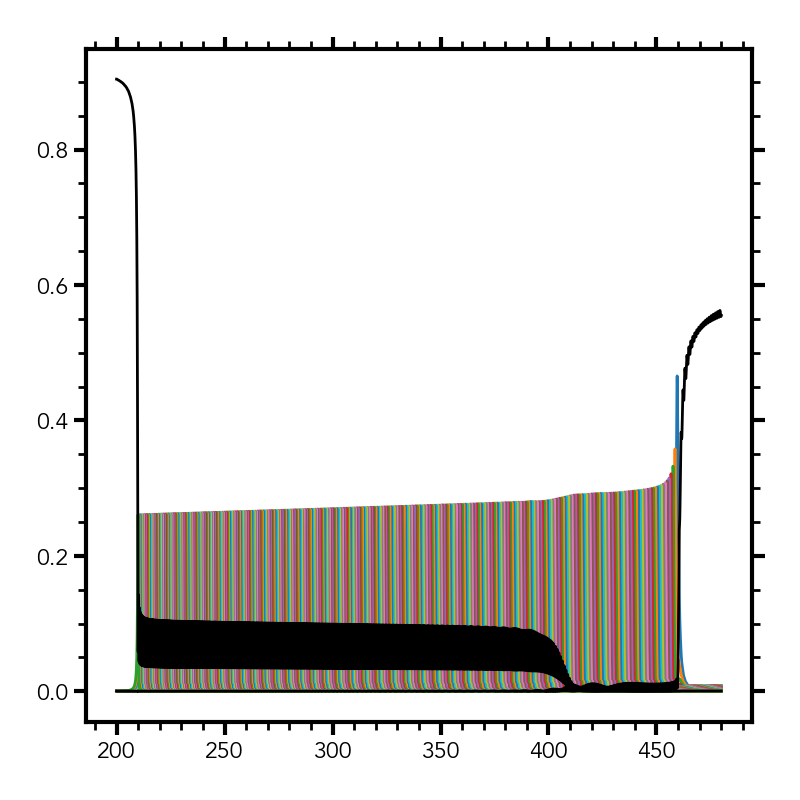

In [13]:
plt.close("all")
plt.figure()

S31_absSq = np.abs(FB_directional.S_param[:,2::2])**2
S41_absSq = np.abs(FB_directional.S_param[:,3::2])**2
plt.plot(FB_directional.f/1e9,FB_directional.S31_absSq_list)
plt.plot(FB_directional.f/1e9,FB_directional.S21_absSq,"k")
plt.plot(FB_directional.f/1e9,FB_directional.S11_absSq,"k")


plt.show()

In [9]:
FB_directional.Filters[0].n_outputs()

2

No such comm: dfd23ea395fe460da69ce26acd159be3


2